# Functional Map of the World (fMoW) - WILDS Version
The [WILDS package](https://wilds.stanford.edu/get_started/) combines several dataset containing distribution shifts, ready for retrieval.

In [139]:
from wilds import get_dataset

## Download

To download the dataset, ssl certification needed to be disabled, because the certificate expired. 

```python
import ssl

ssl._create_default_https_context = ssl._create_unverified_contex
dataset = get_dataset(dataset="fmow", download=True)
```

Also in order to load the dataset with `get_dataset`, the time-date format of the metadata needed to be changed manually to drop millisecond data:
```
sed -i 's/\([0-9]\{2\}:[0-9]\{2\}:[0-9]\{2\}\)\.[0-9]\+\(Z\)/\1\2/' rgb_metadata.csv
```

With the result that:
```
2007-01-21T02:38:01.080Z -> 2007-01-21T02:38:01Z
```

## Metadata Exploration

In [140]:
dataset = get_dataset(dataset="fmow")

In [141]:
print("Metadata fields of fMoW:")
for field in [*dataset.metadata.columns]: 
    print(f"  - {field}")

Metadata fields of fMoW:
  - split
  - img_filename
  - img_path
  - spatial_reference
  - epsg
  - category
  - visible
  - img_width
  - img_height
  - country_code
  - cloud_cover
  - timestamp
  - lat
  - lon
  - region
  - y
  - year


The coordinates of each image center are listed as `(lat, lon)` tuple in the metadata. An additional `bounding box` of the object to classify is not part of the WILDS version.

In [142]:
print("First samples of fMoW:")
print(dataset.metadata.head())

First samples of fMoW:
   split                  img_filename  \
0  train  tunnel_opening_370_6_rgb.jpg   
1  train  tunnel_opening_370_1_rgb.jpg   
2  train  tunnel_opening_370_0_rgb.jpg   
3  train  tunnel_opening_370_3_rgb.jpg   
4  train  tunnel_opening_370_4_rgb.jpg   

                                            img_path spatial_reference  epsg  \
0  train/tunnel_opening/tunnel_opening_370/tunnel...      GCS_WGS_1984  4326   
1  train/tunnel_opening/tunnel_opening_370/tunnel...      GCS_WGS_1984  4326   
2  train/tunnel_opening/tunnel_opening_370/tunnel...      GCS_WGS_1984  4326   
3  train/tunnel_opening/tunnel_opening_370/tunnel...      GCS_WGS_1984  4326   
4  train/tunnel_opening/tunnel_opening_370/tunnel...      GCS_WGS_1984  4326   

         category  visible  img_width  img_height country_code  cloud_cover  \
0  tunnel_opening     True       1359        1222          CHN            0   
1  tunnel_opening     True        900         809          CHN            0   
2  tun

# Image Coordinates
Compare fMoW samples with satellite images augmented at the same coordinates.

In [143]:
import ee
import geemap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from PIL import Image

EE_PROJECT_NAME = 'seeing-the-big-picture'

try:
    ee.Authenticate()
    ee.Initialize(project=EE_PROJECT_NAME)
except Exception as e:
    print("Please authenticate Earth Engine: earthengine authenticate")
    raise

Sample metadata:
split                                                        train
img_filename                                  airport_12_0_rgb.jpg
img_path             train/airport/airport_12/airport_12_0_rgb.jpg
spatial_reference                                     GCS_WGS_1984
epsg                                                          4326
category                                                   airport
visible                                                       True
img_width                                                     8932
img_height                                                    8392
country_code                                                   MRT
cloud_cover                                                      0
timestamp                                     2016-11-06T11:39:20Z
lat                                                      20.925295
lon                                                     -17.037878
region                                       

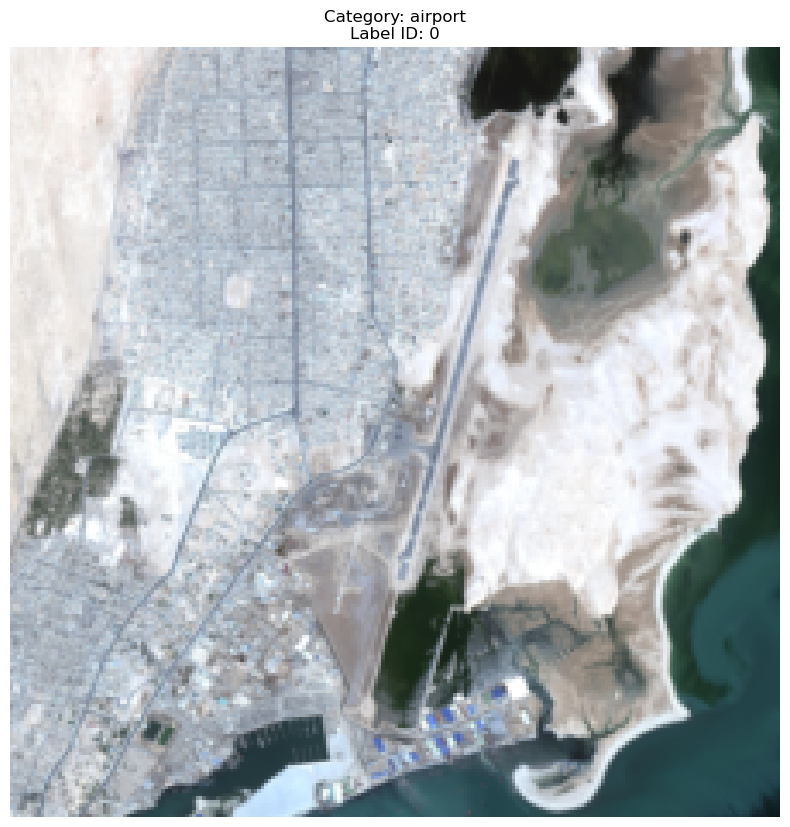

Map(center=[20.92529526136417, -17.037877955261518], controls=(WidgetControl(options=['position', 'transparent…

In [144]:
split = "train"
category = "airport"
sample_id = "12_0"

cond_df = (dataset.metadata["img_filename"] == f"{category}_{sample_id}_rgb.jpg") & \
          (dataset.metadata["split"] == split)
sample_meta_df = dataset.metadata.loc[cond_df]
sample_idx = sample_meta_df.index[0]
sample_meta = sample_meta_df.squeeze()    # Turn pandas dataframe with one element into pandas series
img_pil, y_tensor, _ = dataset[sample_idx]  # Triple: (PIL, label, metadata)

print("Sample metadata:")
print(sample_meta)
print(sample_meta.get('lat', 0))
map_center_lat = float(sample_meta.get('lat', 0))
map_center_lon = float(sample_meta.get('lon', 0))

# Plot sample
img_array = np.array(img_pil)
plt.figure(figsize=(10, 10))
plt.imshow(img_array)
plt.title(f"Category: {sample_meta['category']}\nLabel ID: {y_tensor.item()}")
plt.axis('off')
plt.show()

# Create GEE map
def scale_l8(image):
    return (image
            .select(['SR_B2', 'SR_B3', 'SR_B4'])
            .multiply(0.0000275)
            .add(-0.2))

m = geemap.Map(center=[map_center_lat, map_center_lon], zoom=17)

point = ee.Geometry.Point([map_center_lon, map_center_lat])    
# Load satellite image from 

l8 = (ee.ImageCollection('LANDSAT/LC08/C02/T1_L2') \
    .filterBounds(point) \
    .map(scale_l8))

least_cloudy = l8.sort('CLOUD_COVER').first()

rgb_mask = (least_cloudy
            .select(['SR_B2', 'SR_B3', 'SR_B4'])
            .mask()
            .reduce(ee.Reducer.min()))

coverage_dict = rgb_mask.reduceRegion(
    reducer=ee.Reducer.mean(),
    geometry=point,
    scale=30,
    maxPixels=1e7
)

least_cloudy_coverage = ee.Number(coverage_dict.get('min'))
rgb_ok = least_cloudy_coverage.gte(0.99)

composite = l8.median()
context = ee.Image(ee.Algorithms.If(rgb_ok, least_cloudy, composite))

m.addLayer(
    context,
    {'bands': ['SR_B4', 'SR_B3', 'SR_B2'], 'min': 0, 'max': 0.3},
    'Landsat8'
)
m.add_layer(point, {'color': 'red'}, "Sample Location")
m